# Improving Calibration with Temperature Scaling

In the post on logistic regression, we saw that the model doesn't generate a prediction directly. Rather it generates logits, which are converted to probabilities. In the binary case, this means if the probability is greater then 0.5, the model predicts class 1, otherwise class 0. 

However, these probabilities themselfs don't posses much meaning. We would assume that if a model predicts a probability of 0.8 for a certain class, it should be correct 80% of the time. But this is not the case. The model's predicted probabilities are often not well calibrated, meaning they do not match the true probabilities of the classes.

In this notebook we will explore a way to better calibrate -- align the models probabilities with the likelihood of the predicted class being correct -- using temperature scaling.

## What is temperature?

You might remember the formula for logistic regression:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

We can add a term to this formula, which is called temperature ($T$). The modified formula looks like this:

$$
\sigma_T(z) = \frac{1}{1 + e^{-z/T}}
$$

So in the case of $T=1$, we have the original logistic regression formula. If we increase $T$, the output probabilities become more uniform, meaning they are less confident. If we decrease $T$, the output probabilities become more extreme, meaning they are more confident. Note that this does not change the model's predictions, only the probabilities. The decisiion boundary remains the same.

## Simple example
Lets illustrate this with a simple 1d binary calssification example. We will create a synthetic dataset, fit a logistic regression model, and then apply different temperatures to see how it affects the predicted probabilities.



In [238]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from scipy.optimize import minimize

# Step 1: Load and reduce dataset to 1D
data = load_breast_cancer()
X = data.data[:, data.feature_names.tolist().index('mean radius')].reshape(-1, 1)
y = data.target  # 0 = malignant, 1 = benign

# Step 2: Train/val/test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Step 3: Train logistic regression with regularization
clf = LogisticRegression(C=0.05)  # Add regularization to allow some miscalibration
clf.fit(X_train, y_train)

# Get logits
logits_val = clf.decision_function(X_val)
logits_test = clf.decision_function(X_test)

# Step 4: Fit temperature scaling
def sigmoid(z): return 1 / (1 + np.exp(-z))
def scaled_sigmoid(z, T): return 1 / (1 + np.exp(-z / T))
def nll_loss(T, logits, y_true): return log_loss(y_true, scaled_sigmoid(logits, T))

res = minimize(nll_loss, x0=[1.0], args=(logits_val, y_val), bounds=[(1e-2, 10)])
T_opt = res.x[0]
print(f"Optimal temperature: {T_opt:.2f}")

# Step 5: Get probabilities for test set
probs_uncal = sigmoid(logits_test)
probs_cal = scaled_sigmoid(logits_test, T_opt)


Optimal temperature: 0.54


/tmp/ipykernel_11631/1510462568.py:29: RuntimeWarning: overflow encountered in exp
  def scaled_sigmoid(z, T): return 1 / (1 + np.exp(-z / T))
/tmp/ipykernel_11631/1510462568.py:29: RuntimeWarning: overflow encountered in exp
  def scaled_sigmoid(z, T): return 1 / (1 + np.exp(-z / T))


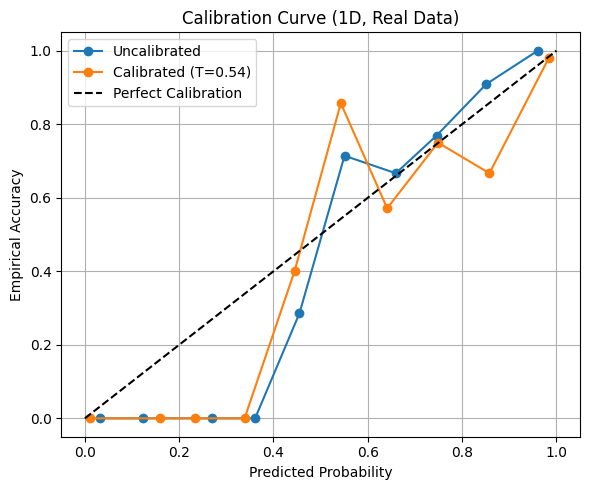

In [239]:
plt.figure(figsize=(6, 5))
for probs, label in zip([probs_uncal, probs_cal], ["Uncalibrated", f"Calibrated (T={T_opt:.2f})"]):
    frac_pos, mean_pred = calibration_curve(y_test, probs, n_bins=10)
    plt.plot(mean_pred, frac_pos, marker='o', label=label)

plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
plt.xlabel("Predicted Probability")
plt.ylabel("Empirical Accuracy")
plt.title("Calibration Curve (1D, Real Data)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


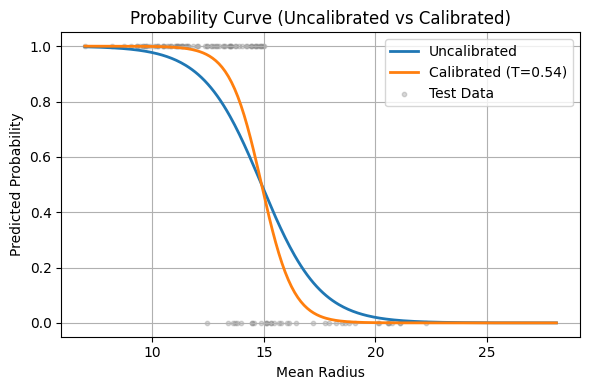

In [240]:
# Plot sigmoid vs calibrated sigmoid across input range
x_range = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
logits_range = clf.decision_function(x_range)
probs_range_uncal = sigmoid(logits_range)
probs_range_cal = scaled_sigmoid(logits_range, T_opt)

plt.figure(figsize=(6, 4))
plt.plot(x_range, probs_range_uncal, label='Uncalibrated', lw=2)
plt.plot(x_range, probs_range_cal, label=f'Calibrated (T={T_opt:.2f})', lw=2)
plt.scatter(X_test, y_test, c='gray', alpha=0.3, label='Test Data', s=10)
plt.xlabel("Mean Radius")
plt.ylabel("Predicted Probability")
plt.title("Probability Curve (Uncalibrated vs Calibrated)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


You can see, the effect of temperature scaling on the predicted probabilities. all the curves still have the same inflection point, but as the temperature increases, the curve flattens out. This means the model becomes less confident in its predictions. The inverse happens when the temperature decreases, the curve becomes steeper, meaning the model appears more confident in its predictions.

# Evaluation
But how do we know which temperature is the "right" one? And can we find it automatically?

The short answer yes. We evaluate using Expected Calibraiton Error (ECE). We bin confidence values, calculate the average accuracy of each bin. Then we take the weighted average of the error of each bin:

$$
ECE = \sum_{m=1}^{M} \frac{|B_m|}{n} | acc(B_m) - conf(B_m)|
$$


To train the model we a validation split


In [187]:
def compute_ece(y_true, probs, n_bins=10):
    """Compute Expected Calibration Error (ECE)"""
    bin_edges = np.linspace(0, 1, n_bins + 1)
    ece = 0.0
    total_count = len(y_true)

    for i in range(n_bins):
        bin_lower, bin_upper = bin_edges[i], bin_edges[i + 1]
        mask = (probs >= bin_lower) & (probs < bin_upper)
        if np.any(mask):
            bin_accuracy = np.mean(y_true[mask])
            bin_confidence = np.mean(probs[mask])
            bin_count = np.sum(mask)
            ece += (bin_count / total_count) * np.abs(bin_accuracy - bin_confidence)
    
    return ece


We can plot each of the bins to get a visual representaiton of the expected claibration error.

# 

In [235]:
def plot_ece(y_true, probs, n_bins=9, label="Model"):
    plt.figure(figsize=(5, 5))
    plt.plot([0, 1], [0, 1], "--", color="gray", label="Perfect Calibration")
    
    bin_edges = np.linspace(0, 1, n_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    width = 1 / n_bins

    ece = 0.0
    total_count = len(y_true)
    
    accs = []
    confs = []
    counts = []

    for i in range(n_bins):
        bin_lower, bin_upper = bin_edges[i], bin_edges[i + 1]
        mask = (probs >= bin_lower) & (probs < bin_upper)
        n_samples = np.sum(mask)

        if n_samples > 0:
            bin_accuracy = np.mean(y_true[mask])
            bin_confidence = np.mean(probs[mask])
            accs.append(bin_accuracy)
            confs.append(bin_confidence)
            counts.append(n_samples)
            ece += np.abs(bin_confidence - bin_accuracy) * n_samples
        else:
            accs.append(0)
            confs.append(0)
            counts.append(0)

    ece /= total_count

    # Plot bars: accuracy per bin
    cmap = plt.get_cmap("Blues")
    colors = cmap(np.array(accs))
    plt.bar(bin_centers, accs, width=width, edgecolor="gray", color=colors, label=f"{label} (ECE = {ece:.3f})")

    plt.xlabel("Confidence")
    plt.ylabel("Accuracy")
    plt.title("Reliability Diagram")
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



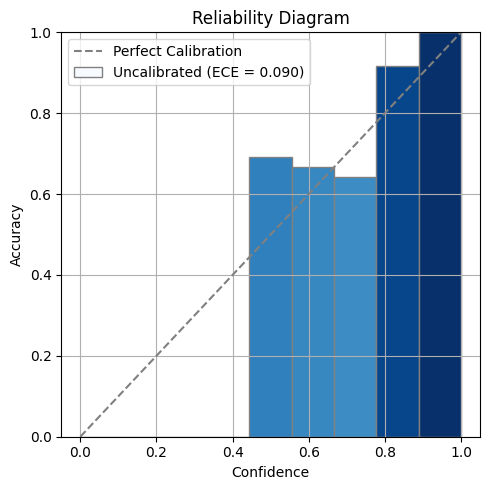

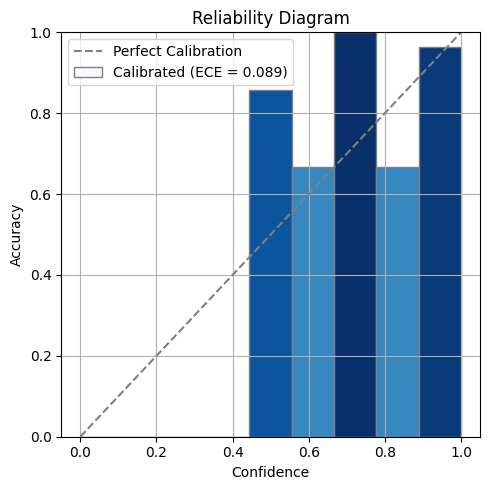

In [241]:
plot_ece(y_test, probs_uncal, label="Uncalibrated")
plot_ece(y_test, probs_cal, label="Calibrated")

In [255]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from scipy.special import softmax
from scipy.optimize import minimize
from matplotlib.colors import ListedColormap

# 1. Create 2D, 3-class dataset
X, y = make_classification(n_samples=5500, n_features=2, n_informative=2, n_redundant=0,
                           n_classes=3, n_clusters_per_class=1, class_sep=1.5, random_state=0)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 2. Train SVM with decision_function
svm = SVC(kernel='rbf', decision_function_shape='ovr', probability=False)
svm.fit(X_train, y_train)

# 3. Extract logits (OvR: One-vs-Rest)
logits_val = svm.decision_function(X_val)
logits_test = svm.decision_function(X_test)


In [256]:
def softmax_temp(logits, T):
    return softmax(logits / T, axis=1)

def nll_loss(T, logits, y_true):
    probs = softmax_temp(logits, T)
    return log_loss(y_true, probs)

res = minimize(nll_loss, x0=[1.0], args=(logits_val, y_val), bounds=[(1e-2, 10)])
T_opt = res.x[0]
print(f"Optimal temperature: {T_opt:.2f}")

probs_uncal = softmax(logits_test, axis=1)
probs_cal = softmax(logits_test / T_opt, axis=1)

Optimal temperature: 0.33


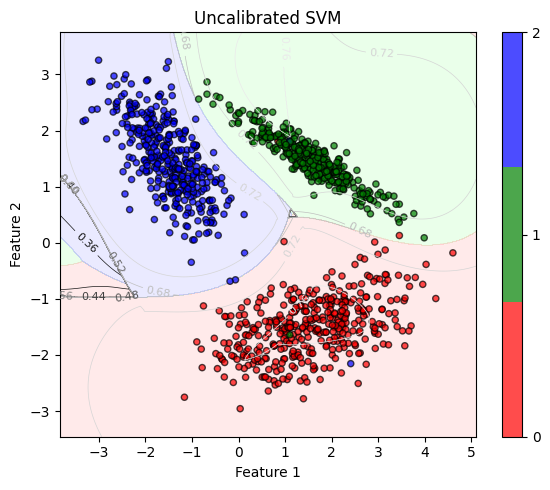

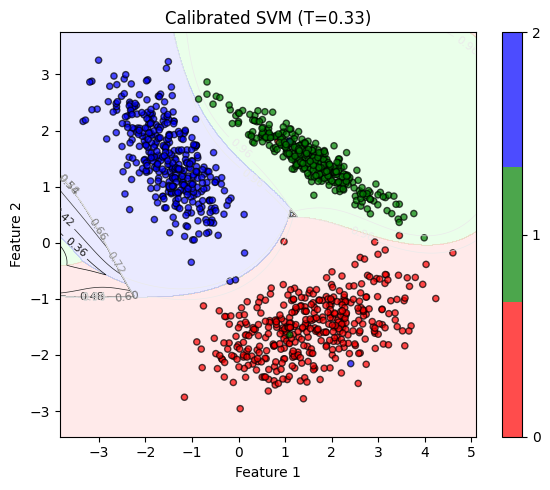

In [257]:
def plot_decision_boundary(X, y, model, T=1.0, title=""):
    h = 0.01
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    grid = np.c_[xx.ravel(), yy.ravel()]
    logits = model.decision_function(grid)
    probs = softmax(logits / T, axis=1)
    preds = np.argmax(probs, axis=1)
    confs = np.max(probs, axis=1)

    preds = preds.reshape(xx.shape)
    confs = confs.reshape(xx.shape)

    plt.figure(figsize=(6, 5))
    plt.contourf(xx, yy, preds, alpha=0.3, cmap=ListedColormap(['#FFBBBB', '#BBFFBB', '#BBBBFF']))
    cs = plt.contour(xx, yy, confs, levels=10, linewidths=0.5, cmap='gray')
    plt.clabel(cs, inline=1, fontsize=8, fmt="%.2f")

    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(['r', 'g', 'b']), edgecolor='k', s=20, alpha=0.7)
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.colorbar(scatter, ticks=[0, 1, 2])
    plt.tight_layout()
    plt.show()

plot_decision_boundary(X_test, y_test, svm, T=1.0, title="Uncalibrated SVM")
plot_decision_boundary(X_test, y_test, svm, T=T_opt, title=f"Calibrated SVM (T={T_opt:.2f})")

In [259]:
def plot_multiclass_ece_per_class(y_true, probs, n_bins=10, label="Model"):
    n_classes = probs.shape[1]
    bin_edges = np.linspace(0, 1, n_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_width = 1 / n_bins
    bar_width = bin_width / n_classes

    ece_total = 0
    total = len(y_true)
    
    plt.figure(figsize=(7, 5))
    plt.plot([0, 1], [0, 1], 'k--', label='Perfect calibration')

    colors = ['tab:red', 'tab:green', 'tab:blue']
    class_names = [f"Class {i}" for i in range(n_classes)]
    
    for c in range(n_classes):
        accs = []
        for i in range(n_bins):
            lower, upper = bin_edges[i], bin_edges[i+1]
            mask = (probs[:, c] >= lower) & (probs[:, c] < upper)
            if np.any(mask):
                acc = np.mean((y_true[mask] == c).astype(float))
                conf = np.mean(probs[mask, c])
                ece_total += np.abs(acc - conf) * len(mask)
            else:
                acc = 0.0
            accs.append(acc)

        # Slightly offset each bar by class
        bar_positions = bin_centers - bin_width/2 + (c + 0.5) * bar_width
        plt.bar(bar_positions, accs, width=bar_width, alpha=0.8,
                label=f"{class_names[c]}", color=colors[c], edgecolor='gray')

    ece_total /= total
    plt.xlabel("Confidence")
    plt.ylabel("Accuracy")
    plt.title(f"Multiclass Reliability Diagram: {label} (ECE={ece_total:.3f})")
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


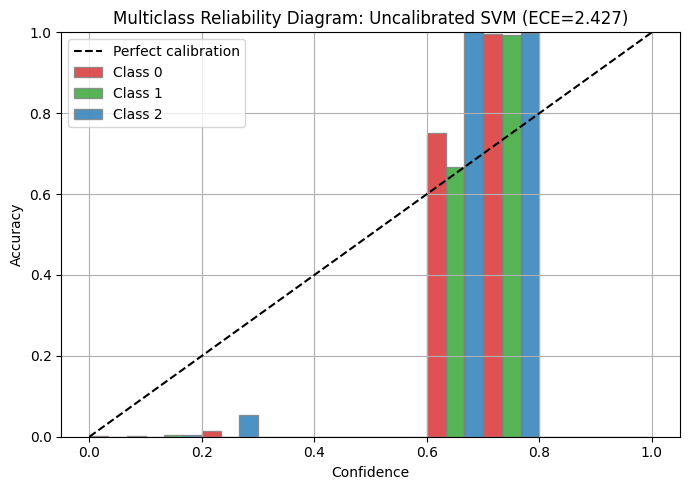

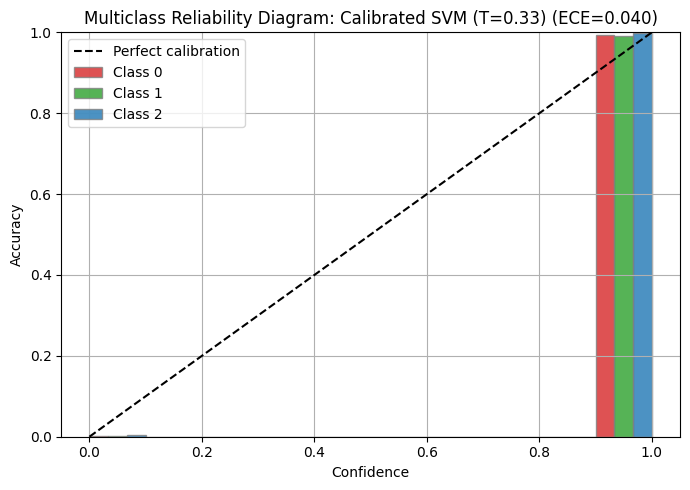

In [260]:
plot_multiclass_ece_per_class(y_test, probs_uncal, label="Uncalibrated SVM")
plot_multiclass_ece_per_class(y_test, probs_cal, label=f"Calibrated SVM (T={T_opt:.2f})")
